In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn.functional as F


import torchvision
from torchvision.models import resnet18, ResNet18_Weights, vgg16, VGG16_Weights
from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


import os
import sys
from torchsummary import summary


#device config
torch.cuda.set_device(0)#Select GPU device 1
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Get Packages
sys.path.append('./Tools')
from AdversarialExamples import GetAdversarialExamples

#Network architectures
from ResNet18_CIFAR10 import ResNet18_CIFAR10_Model
from ResNet18_TINYIMAGENET import ResNet18_TINYIMAGENET_Model
from VGG16_CIFAR10 import VGG16_CIFAR10_Model
from VGG16_TINYIMAGENET import VGG16_TINYIMAGENET_Model

#Non Corrupted DataLoaders
from CIFAR10_LOADER import CIFAR10DataLoader
from TINYIMAGENET_LOADER import TINYIMAGENETDataLoader

#Non Corrupted DataLoaders
from CIFAR10C_LOADER import CIFAR10C_DataLoader #Each Corruption is a entry in the dictionary
from TINYIMAGENET_C_LOADER import TinyImagenetC_DataLoader #Each Corruption is a entry in the dictionary

#Error Metrics
from ErrorMetrics import Evaluate_Model_TOP1


# Unpruned Models / And Original Datasets

In [2]:
#Network weights
ResNet18_CIFAR10_Weights= torch.load("./Networks/ResNet18_CIFAR10_V0.pt")
ResNet18_TINYIMAGENET_Weights=torch.load("./Networks/ResNet18_TINY_IMAGENET_V0.pt")
VGG16_CIFAR10_Weights=torch.load("./Networks/VGG16_CIFAR10_V0.pt")
VGG16_TINYIMAGENET_Weights=torch.load("./Networks/VGG16_TINY_IMAGENET_V0.pt")

#Unpruned Models
ResNet18_CIFAR10_0P=ResNet18_CIFAR10_Model()
ResNet18_CIFAR10_0P.load_state_dict(ResNet18_CIFAR10_Weights)

ResNet18_TINYIMAGENET_0P=ResNet18_TINYIMAGENET_Model()
ResNet18_TINYIMAGENET_0P.load_state_dict(ResNet18_TINYIMAGENET_Weights)

VGG16_CIFAR10_0P=VGG16_CIFAR10_Model()
VGG16_CIFAR10_0P.load_state_dict(VGG16_CIFAR10_Weights)

VGG16_TINYIMAGENET_0P=VGG16_TINYIMAGENET_Model()
VGG16_TINYIMAGENET_0P.load_state_dict(VGG16_TINYIMAGENET_Weights)

#Datasets
from unittest import loader
Times=1
trainloader_CIFAR10, testloader_CIFAR10=CIFAR10DataLoader(batch_size=512*Times) #Load Data for CIFAR10
trainloader_TINYIMAGENET, testloader_TINYIMAGENET=TINYIMAGENETDataLoader(NPZ=True,batch_size=512*Times) #Load Data for TINYIMAGENET
loader_CIFAR10C=CIFAR10C_DataLoader(batch_size=512*Times) #Load Data for CIFAR10C
loader_TinyImagenetC=TinyImagenetC_DataLoader(NPZ=True,batch_size=512*Times) #Load Data for TINYIMAGENETC


#
MeanCIFAR10=(0.491, 0.482, 0.446)
StdCIFAR10=(0.247, 0.243, 0.261)
MeanImagenet=(0.485, 0.456, 0.406)
StdImagenet=(0.229, 0.224, 0.225)

Files already downloaded and verified
Files already downloaded and verified


# Training With Adversarial

In [3]:
def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses, epsilon, mean, std):

    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        data=GetAdversarialExamples(model, data, target, device, epsilon=epsilon, mean=mean, std=std)


        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target) #negative log likelihood loss


        train_losses.append(loss.item())
        loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update).

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):

    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified


# Epsilon 0.05

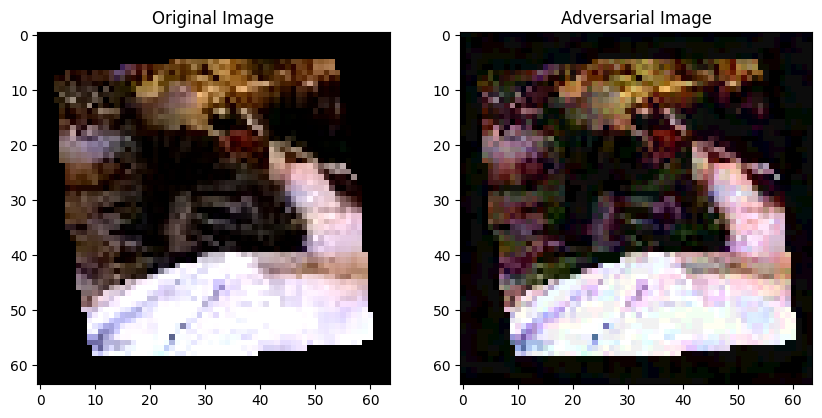

In [4]:
epsilon=0.05
mean=MeanImagenet
std=StdImagenet
model=ResNet18_TINYIMAGENET_0P
trainloader=trainloader_TINYIMAGENET
testloader=testloader_TINYIMAGENET

#Check Images for epsion levels
for data, target in trainloader:
    data, target = data.to(device), target.to(device)
    data_Adv=GetAdversarialExamples(model, data, target, device, epsilon=epsilon, mean=mean, std=std)

    data = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data)
    data_Adv = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data_Adv)
    break

IdxImage=np.random.randint(0,data.shape[0])
with torch.no_grad():
    #plot an image from data and from data_Adv
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(data[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(data_Adv[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Adversarial Image")
    plt.show()


In [5]:

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 100

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses, epsilon, mean, std)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)
    
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/ResNet18_TinyImagenet_V0_Adversarial_ep_5p.pt")
        np.savez("./Networks/TrainSteps_ResNet18_TinyImagenet_V0_Adversarial_ep_5p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/ResNet18_TinyImagenet_V0_Adversarial_ep_5p.pt")
np.savez("./Networks/TrainSteps_ResNet18_TinyImagenet_V0_Adversarial_ep_5p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

EPOCHS : 0


Loss=5.1022748947143555 Batch_id=195 Accuracy=3.35: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s]



Test set: Average loss: 4.0619, Accuracy: 948/5000 (18.96%)

EPOCHS : 1


Loss=4.797888278961182 Batch_id=195 Accuracy=4.62: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 3.8185, Accuracy: 1124/5000 (22.48%)

EPOCHS : 2


Loss=4.623526096343994 Batch_id=195 Accuracy=5.64: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 3.7142, Accuracy: 1216/5000 (24.32%)

EPOCHS : 3


Loss=4.646237373352051 Batch_id=195 Accuracy=6.49: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 3.6014, Accuracy: 1308/5000 (26.16%)

EPOCHS : 4


Loss=4.593902111053467 Batch_id=195 Accuracy=7.08: 100%|██████████| 196/196 [02:26<00:00,  1.33it/s] 



Test set: Average loss: 3.5236, Accuracy: 1321/5000 (26.42%)

EPOCHS : 5


Loss=4.622334957122803 Batch_id=195 Accuracy=7.66: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s] 



Test set: Average loss: 3.4590, Accuracy: 1424/5000 (28.48%)

EPOCHS : 6


Loss=4.655618667602539 Batch_id=195 Accuracy=8.02: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s] 



Test set: Average loss: 3.4184, Accuracy: 1452/5000 (29.04%)

EPOCHS : 7


Loss=4.603226184844971 Batch_id=195 Accuracy=8.38: 100%|██████████| 196/196 [02:25<00:00,  1.34it/s] 

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 3.3928, Accuracy: 1491/5000 (29.82%)

EPOCHS : 8


Loss=4.729335784912109 Batch_id=195 Accuracy=9.18: 100%|██████████| 196/196 [02:25<00:00,  1.35it/s] 



Test set: Average loss: 3.3468, Accuracy: 1544/5000 (30.88%)

EPOCHS : 9


Loss=4.421520233154297 Batch_id=195 Accuracy=9.49: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s] 



Test set: Average loss: 3.3332, Accuracy: 1546/5000 (30.92%)

EPOCHS : 10


Loss=4.459929943084717 Batch_id=195 Accuracy=9.47: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s] 



Test set: Average loss: 3.3210, Accuracy: 1564/5000 (31.28%)

EPOCHS : 11


Loss=4.397773742675781 Batch_id=195 Accuracy=9.41: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s] 



Test set: Average loss: 3.3186, Accuracy: 1566/5000 (31.32%)

EPOCHS : 12


Loss=4.413500785827637 Batch_id=195 Accuracy=9.52: 100%|██████████| 196/196 [02:25<00:00,  1.34it/s] 



Test set: Average loss: 3.3051, Accuracy: 1572/5000 (31.44%)

EPOCHS : 13


Loss=4.516712188720703 Batch_id=195 Accuracy=9.55: 100%|██████████| 196/196 [02:25<00:00,  1.34it/s] 



Test set: Average loss: 3.3019, Accuracy: 1576/5000 (31.52%)

EPOCHS : 14


Loss=4.625880241394043 Batch_id=195 Accuracy=9.54: 100%|██████████| 196/196 [02:25<00:00,  1.34it/s] 

Epoch 00015: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 3.2993, Accuracy: 1574/5000 (31.48%)

EPOCHS : 15


Loss=4.522253513336182 Batch_id=195 Accuracy=9.57: 100%|██████████| 196/196 [02:25<00:00,  1.34it/s] 



Test set: Average loss: 3.2948, Accuracy: 1576/5000 (31.52%)

EPOCHS : 16


Loss=4.449936389923096 Batch_id=195 Accuracy=9.65: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.3015, Accuracy: 1573/5000 (31.46%)

EPOCHS : 17


Loss=4.319918155670166 Batch_id=195 Accuracy=9.59: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2953, Accuracy: 1582/5000 (31.64%)

EPOCHS : 18


Loss=4.507287502288818 Batch_id=195 Accuracy=9.61: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.3072, Accuracy: 1572/5000 (31.44%)

EPOCHS : 19


Loss=4.3973493576049805 Batch_id=195 Accuracy=9.79: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s]



Test set: Average loss: 3.2972, Accuracy: 1578/5000 (31.56%)

EPOCHS : 20


Loss=4.24603271484375 Batch_id=195 Accuracy=9.58: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s]  



Test set: Average loss: 3.3043, Accuracy: 1584/5000 (31.68%)

EPOCHS : 21


Loss=4.147015571594238 Batch_id=195 Accuracy=9.79: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.3056, Accuracy: 1586/5000 (31.72%)

EPOCHS : 22


Loss=4.368441581726074 Batch_id=195 Accuracy=9.69: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.3008, Accuracy: 1574/5000 (31.48%)

EPOCHS : 23


Loss=4.2823076248168945 Batch_id=195 Accuracy=9.69: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s]



Test set: Average loss: 3.2958, Accuracy: 1576/5000 (31.52%)

EPOCHS : 24


Loss=4.350950717926025 Batch_id=195 Accuracy=9.57: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 

Epoch 00025: reducing learning rate of group 0 to 1.2500e-06.



Test set: Average loss: 3.3027, Accuracy: 1585/5000 (31.70%)

EPOCHS : 25


Loss=4.28273344039917 Batch_id=195 Accuracy=9.64: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s]  



Test set: Average loss: 3.3024, Accuracy: 1578/5000 (31.56%)

EPOCHS : 26


Loss=4.465616226196289 Batch_id=195 Accuracy=9.65: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2932, Accuracy: 1580/5000 (31.60%)

EPOCHS : 27


Loss=4.4570441246032715 Batch_id=195 Accuracy=9.69: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s]

Epoch 00028: reducing learning rate of group 0 to 6.2500e-08.



Test set: Average loss: 3.2961, Accuracy: 1581/5000 (31.62%)

EPOCHS : 28


Loss=4.523774147033691 Batch_id=195 Accuracy=9.70: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2947, Accuracy: 1578/5000 (31.56%)

EPOCHS : 29


Loss=4.530464172363281 Batch_id=195 Accuracy=9.65: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2814, Accuracy: 1578/5000 (31.56%)

EPOCHS : 30


Loss=4.241587162017822 Batch_id=195 Accuracy=9.60: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 

Epoch 00031: reducing learning rate of group 0 to 3.1250e-09.



Test set: Average loss: 3.2983, Accuracy: 1582/5000 (31.64%)

EPOCHS : 31


Loss=4.3365325927734375 Batch_id=195 Accuracy=9.64: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s]



Test set: Average loss: 3.2833, Accuracy: 1580/5000 (31.60%)

EPOCHS : 32


Loss=4.424249172210693 Batch_id=195 Accuracy=9.64: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2921, Accuracy: 1571/5000 (31.42%)

EPOCHS : 33


Loss=4.718662738800049 Batch_id=195 Accuracy=9.60: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2998, Accuracy: 1582/5000 (31.64%)

EPOCHS : 34


Loss=4.612305641174316 Batch_id=195 Accuracy=9.67: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2913, Accuracy: 1576/5000 (31.52%)

EPOCHS : 35


Loss=4.359009742736816 Batch_id=195 Accuracy=9.58: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.3009, Accuracy: 1586/5000 (31.72%)

EPOCHS : 36


Loss=4.625833034515381 Batch_id=195 Accuracy=9.70: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2814, Accuracy: 1575/5000 (31.50%)

EPOCHS : 37


Loss=4.515384674072266 Batch_id=195 Accuracy=9.74: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.3023, Accuracy: 1582/5000 (31.64%)

EPOCHS : 38


Loss=4.549426078796387 Batch_id=195 Accuracy=9.74: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2886, Accuracy: 1575/5000 (31.50%)

EPOCHS : 39


Loss=4.453301906585693 Batch_id=195 Accuracy=9.58: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.3005, Accuracy: 1579/5000 (31.58%)

EPOCHS : 40


Loss=4.4598259925842285 Batch_id=195 Accuracy=9.68: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s]



Test set: Average loss: 3.2913, Accuracy: 1589/5000 (31.78%)

EPOCHS : 41


Loss=4.371546745300293 Batch_id=195 Accuracy=9.67: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.3055, Accuracy: 1578/5000 (31.56%)

EPOCHS : 42


Loss=4.545065879821777 Batch_id=195 Accuracy=9.70: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.3015, Accuracy: 1590/5000 (31.80%)

EPOCHS : 43


Loss=4.1647748947143555 Batch_id=195 Accuracy=9.78: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s]



Test set: Average loss: 3.3099, Accuracy: 1578/5000 (31.56%)

EPOCHS : 44


Loss=4.412695407867432 Batch_id=195 Accuracy=9.66: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2927, Accuracy: 1588/5000 (31.76%)

EPOCHS : 45


Loss=4.5458598136901855 Batch_id=195 Accuracy=9.69: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s]



Test set: Average loss: 3.2972, Accuracy: 1585/5000 (31.70%)

EPOCHS : 46


Loss=4.544317722320557 Batch_id=195 Accuracy=9.74: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.3009, Accuracy: 1577/5000 (31.54%)

EPOCHS : 47


Loss=4.373434066772461 Batch_id=195 Accuracy=9.63: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2976, Accuracy: 1580/5000 (31.60%)

EPOCHS : 48


Loss=4.345504283905029 Batch_id=195 Accuracy=9.61: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2925, Accuracy: 1578/5000 (31.56%)

EPOCHS : 49


Loss=4.471691608428955 Batch_id=195 Accuracy=9.62: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2914, Accuracy: 1578/5000 (31.56%)

EPOCHS : 50


Loss=4.425294399261475 Batch_id=195 Accuracy=9.68: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.3049, Accuracy: 1584/5000 (31.68%)

EPOCHS : 51


Loss=4.471999168395996 Batch_id=195 Accuracy=9.63: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2874, Accuracy: 1596/5000 (31.92%)

EPOCHS : 52


Loss=4.368236064910889 Batch_id=195 Accuracy=9.67: 100%|██████████| 196/196 [02:23<00:00,  1.36it/s] 



Test set: Average loss: 3.2985, Accuracy: 1587/5000 (31.74%)

EPOCHS : 53


Loss=4.49594783782959 Batch_id=195 Accuracy=9.57: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s]  



Test set: Average loss: 3.3001, Accuracy: 1584/5000 (31.68%)

EPOCHS : 54


Loss=4.482403755187988 Batch_id=195 Accuracy=9.59: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2832, Accuracy: 1585/5000 (31.70%)

EPOCHS : 55


Loss=4.337359428405762 Batch_id=195 Accuracy=9.67: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.3015, Accuracy: 1578/5000 (31.56%)

EPOCHS : 56


Loss=4.446918487548828 Batch_id=195 Accuracy=9.72: 100%|██████████| 196/196 [02:24<00:00,  1.35it/s] 



Test set: Average loss: 3.3009, Accuracy: 1581/5000 (31.62%)

EPOCHS : 57


Loss=4.589571475982666 Batch_id=195 Accuracy=9.73: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2892, Accuracy: 1579/5000 (31.58%)

EPOCHS : 58


Loss=4.490140438079834 Batch_id=195 Accuracy=9.70: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2892, Accuracy: 1599/5000 (31.98%)

EPOCHS : 59


Loss=4.551429271697998 Batch_id=195 Accuracy=9.73: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2933, Accuracy: 1590/5000 (31.80%)

EPOCHS : 60


Loss=4.380725860595703 Batch_id=195 Accuracy=9.69: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2919, Accuracy: 1590/5000 (31.80%)

EPOCHS : 61


Loss=4.502459526062012 Batch_id=195 Accuracy=9.61: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2968, Accuracy: 1584/5000 (31.68%)

EPOCHS : 62


Loss=4.418463706970215 Batch_id=195 Accuracy=9.61: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.3008, Accuracy: 1583/5000 (31.66%)

EPOCHS : 63


Loss=4.337281227111816 Batch_id=195 Accuracy=9.65: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2922, Accuracy: 1577/5000 (31.54%)

EPOCHS : 64


Loss=4.464632987976074 Batch_id=195 Accuracy=9.68: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2955, Accuracy: 1590/5000 (31.80%)

EPOCHS : 65


Loss=4.520815849304199 Batch_id=195 Accuracy=9.73: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2922, Accuracy: 1590/5000 (31.80%)

EPOCHS : 66


Loss=4.4088239669799805 Batch_id=195 Accuracy=9.72: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s]



Test set: Average loss: 3.2976, Accuracy: 1584/5000 (31.68%)

EPOCHS : 67


Loss=4.339400291442871 Batch_id=195 Accuracy=9.78: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.3088, Accuracy: 1570/5000 (31.40%)

EPOCHS : 68


Loss=4.429104328155518 Batch_id=195 Accuracy=9.70: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2962, Accuracy: 1580/5000 (31.60%)

EPOCHS : 69


Loss=4.279475688934326 Batch_id=195 Accuracy=9.65: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2922, Accuracy: 1579/5000 (31.58%)

EPOCHS : 70


Loss=4.421555042266846 Batch_id=195 Accuracy=9.61: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2933, Accuracy: 1593/5000 (31.86%)

EPOCHS : 71


Loss=4.601046562194824 Batch_id=195 Accuracy=9.62: 100%|██████████| 196/196 [02:24<00:00,  1.35it/s] 



Test set: Average loss: 3.2890, Accuracy: 1584/5000 (31.68%)

EPOCHS : 72


Loss=4.451248645782471 Batch_id=195 Accuracy=9.78: 100%|██████████| 196/196 [02:25<00:00,  1.34it/s] 



Test set: Average loss: 3.2941, Accuracy: 1591/5000 (31.82%)

EPOCHS : 73


Loss=4.377302169799805 Batch_id=195 Accuracy=9.60: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 3.2990, Accuracy: 1577/5000 (31.54%)

EPOCHS : 74


Loss=4.626492977142334 Batch_id=195 Accuracy=9.73: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 3.2879, Accuracy: 1589/5000 (31.78%)

EPOCHS : 75


Loss=4.36043119430542 Batch_id=195 Accuracy=9.59: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s]  



Test set: Average loss: 3.3032, Accuracy: 1574/5000 (31.48%)

EPOCHS : 76


Loss=4.650543689727783 Batch_id=195 Accuracy=9.65: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.3066, Accuracy: 1588/5000 (31.76%)

EPOCHS : 77


Loss=4.603142738342285 Batch_id=195 Accuracy=9.75: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2876, Accuracy: 1579/5000 (31.58%)

EPOCHS : 78


Loss=4.416889667510986 Batch_id=195 Accuracy=9.62: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.3014, Accuracy: 1578/5000 (31.56%)

EPOCHS : 79


Loss=4.436548709869385 Batch_id=195 Accuracy=9.73: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2855, Accuracy: 1582/5000 (31.64%)

EPOCHS : 80


Loss=4.520649433135986 Batch_id=195 Accuracy=9.61: 100%|██████████| 196/196 [02:24<00:00,  1.36it/s] 



Test set: Average loss: 3.2839, Accuracy: 1583/5000 (31.66%)

EPOCHS : 81


Loss=4.534661769866943 Batch_id=195 Accuracy=9.63: 100%|██████████| 196/196 [02:25<00:00,  1.35it/s] 



Test set: Average loss: 3.2941, Accuracy: 1589/5000 (31.78%)

EPOCHS : 82


Loss=4.349037170410156 Batch_id=195 Accuracy=9.65: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s] 



Test set: Average loss: 3.2892, Accuracy: 1576/5000 (31.52%)

EPOCHS : 83


Loss=4.470895767211914 Batch_id=195 Accuracy=9.69: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 3.2908, Accuracy: 1585/5000 (31.70%)

EPOCHS : 84


Loss=4.4969587326049805 Batch_id=195 Accuracy=9.64: 100%|██████████| 196/196 [02:34<00:00,  1.27it/s]



Test set: Average loss: 3.2946, Accuracy: 1589/5000 (31.78%)

EPOCHS : 85


Loss=4.389613151550293 Batch_id=195 Accuracy=9.62: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 3.2986, Accuracy: 1581/5000 (31.62%)

EPOCHS : 86


Loss=4.5742716789245605 Batch_id=195 Accuracy=9.63: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s]



Test set: Average loss: 3.2865, Accuracy: 1581/5000 (31.62%)

EPOCHS : 87


Loss=4.49631929397583 Batch_id=195 Accuracy=9.69: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]  



Test set: Average loss: 3.2961, Accuracy: 1579/5000 (31.58%)

EPOCHS : 88


Loss=4.389552116394043 Batch_id=195 Accuracy=9.78: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 3.2964, Accuracy: 1584/5000 (31.68%)

EPOCHS : 89


Loss=4.584692478179932 Batch_id=195 Accuracy=9.72: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 3.2980, Accuracy: 1581/5000 (31.62%)

EPOCHS : 90


Loss=4.489314556121826 Batch_id=195 Accuracy=9.71: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 3.3015, Accuracy: 1587/5000 (31.74%)

EPOCHS : 91


Loss=4.226317882537842 Batch_id=195 Accuracy=9.65: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 3.3008, Accuracy: 1577/5000 (31.54%)

EPOCHS : 92


Loss=4.358768939971924 Batch_id=195 Accuracy=9.63: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 3.2934, Accuracy: 1586/5000 (31.72%)

EPOCHS : 93


Loss=4.6843671798706055 Batch_id=195 Accuracy=9.58: 100%|██████████| 196/196 [02:26<00:00,  1.33it/s]



Test set: Average loss: 3.2862, Accuracy: 1570/5000 (31.40%)

EPOCHS : 94


Loss=4.468404769897461 Batch_id=195 Accuracy=9.65: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s] 



Test set: Average loss: 3.2949, Accuracy: 1581/5000 (31.62%)

EPOCHS : 95


Loss=4.303498268127441 Batch_id=195 Accuracy=9.71: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 3.2884, Accuracy: 1587/5000 (31.74%)

EPOCHS : 96


Loss=4.266266345977783 Batch_id=195 Accuracy=9.65: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s] 



Test set: Average loss: 3.2926, Accuracy: 1574/5000 (31.48%)

EPOCHS : 97


Loss=4.470351219177246 Batch_id=195 Accuracy=9.63: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s] 



Test set: Average loss: 3.3019, Accuracy: 1581/5000 (31.62%)

EPOCHS : 98


Loss=4.538262844085693 Batch_id=195 Accuracy=9.72: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 3.2970, Accuracy: 1583/5000 (31.66%)

EPOCHS : 99


Loss=4.570148468017578 Batch_id=195 Accuracy=9.72: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 3.2960, Accuracy: 1585/5000 (31.70%)



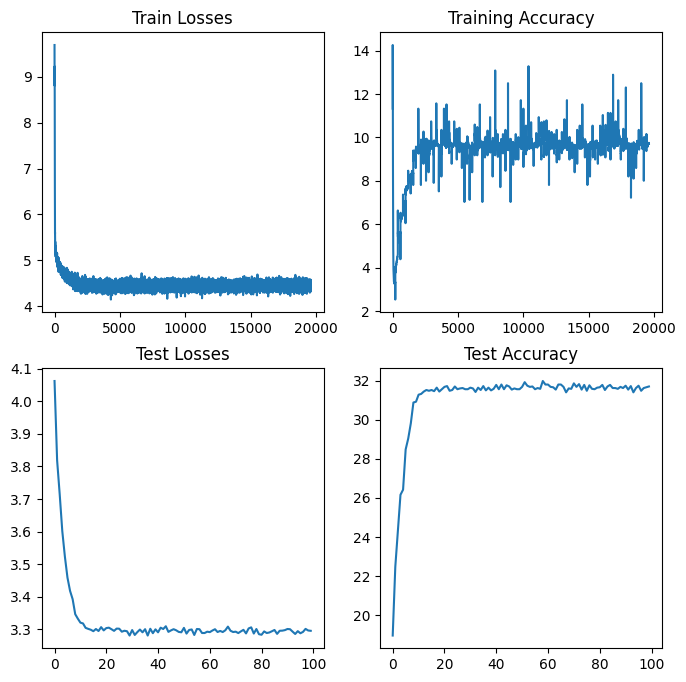

In [6]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)

# Epsilon 0.03

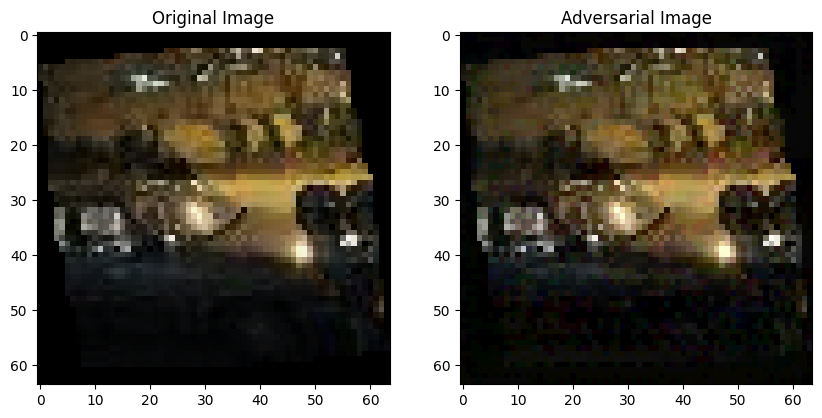

In [7]:
epsilon=0.03
mean=MeanImagenet
std=StdImagenet
model=ResNet18_TINYIMAGENET_0P
trainloader=trainloader_TINYIMAGENET
testloader=testloader_TINYIMAGENET

#Check Images for epsion levels
for data, target in trainloader:
    data, target = data.to(device), target.to(device)
    data_Adv=GetAdversarialExamples(model, data, target, device, epsilon=epsilon, mean=mean, std=std)

    data = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data)
    data_Adv = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data_Adv)
    break

IdxImage=np.random.randint(0,data.shape[0])
with torch.no_grad():
    #plot an image from data and from data_Adv
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(data[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(data_Adv[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Adversarial Image")
    plt.show()


In [8]:
epsilon=0.03
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 100

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses, epsilon, mean, std)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)
    
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/ResNet18_TinyImagenet_V0_Adversarial_ep_3p.pt")
        np.savez("./Networks/TrainSteps_ResNet18_TinyImagenet_V0_Adversarial_ep_3p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/ResNet18_TinyImagenet_V0_Adversarial_ep_3p.pt")
np.savez("./Networks/TrainSteps_ResNet18_TinyImagenet_V0_Adversarial_ep_3p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

EPOCHS : 0


Loss=3.9943675994873047 Batch_id=195 Accuracy=15.58: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.7988, Accuracy: 1885/5000 (37.70%)

EPOCHS : 1


Loss=3.783982515335083 Batch_id=195 Accuracy=16.38: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 2.7177, Accuracy: 1973/5000 (39.46%)

EPOCHS : 2


Loss=3.4225475788116455 Batch_id=195 Accuracy=16.91: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.7024, Accuracy: 1957/5000 (39.14%)

EPOCHS : 3


Loss=3.7273831367492676 Batch_id=195 Accuracy=17.54: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.6537, Accuracy: 2021/5000 (40.42%)

EPOCHS : 4


Loss=3.5008883476257324 Batch_id=195 Accuracy=18.11: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.6223, Accuracy: 2031/5000 (40.62%)

EPOCHS : 5


Loss=3.729008436203003 Batch_id=195 Accuracy=18.58: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 2.5901, Accuracy: 2101/5000 (42.02%)

EPOCHS : 6


Loss=3.569802761077881 Batch_id=195 Accuracy=20.12: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 2.5266, Accuracy: 2132/5000 (42.64%)

EPOCHS : 7


Loss=3.4925670623779297 Batch_id=195 Accuracy=20.56: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5128, Accuracy: 2153/5000 (43.06%)

EPOCHS : 8


Loss=3.736724853515625 Batch_id=195 Accuracy=20.62: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 

Epoch 00009: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 2.5145, Accuracy: 2154/5000 (43.08%)

EPOCHS : 9


Loss=3.415571689605713 Batch_id=195 Accuracy=20.82: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 2.5106, Accuracy: 2161/5000 (43.22%)

EPOCHS : 10


Loss=3.424663543701172 Batch_id=195 Accuracy=20.74: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.5117, Accuracy: 2143/5000 (42.86%)

EPOCHS : 11


Loss=3.6006546020507812 Batch_id=195 Accuracy=20.84: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.5056, Accuracy: 2157/5000 (43.14%)

EPOCHS : 12


Loss=3.6298985481262207 Batch_id=195 Accuracy=20.75: 100%|██████████| 196/196 [02:26<00:00,  1.33it/s]

Epoch 00013: reducing learning rate of group 0 to 1.2500e-06.



Test set: Average loss: 2.5057, Accuracy: 2165/5000 (43.30%)

EPOCHS : 13


Loss=3.6001453399658203 Batch_id=195 Accuracy=20.69: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s]



Test set: Average loss: 2.5040, Accuracy: 2167/5000 (43.34%)

EPOCHS : 14


Loss=3.4584579467773438 Batch_id=195 Accuracy=20.82: 100%|██████████| 196/196 [02:26<00:00,  1.33it/s]



Test set: Average loss: 2.5032, Accuracy: 2156/5000 (43.12%)

EPOCHS : 15


Loss=3.5288658142089844 Batch_id=195 Accuracy=20.91: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s]

Epoch 00016: reducing learning rate of group 0 to 6.2500e-08.



Test set: Average loss: 2.5104, Accuracy: 2155/5000 (43.10%)

EPOCHS : 16


Loss=3.333472490310669 Batch_id=195 Accuracy=20.89: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 2.5084, Accuracy: 2161/5000 (43.22%)

EPOCHS : 17


Loss=3.9310786724090576 Batch_id=195 Accuracy=20.75: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5058, Accuracy: 2162/5000 (43.24%)

EPOCHS : 18


Loss=3.523738145828247 Batch_id=195 Accuracy=20.89: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.5088, Accuracy: 2154/5000 (43.08%)

EPOCHS : 19


Loss=3.552112579345703 Batch_id=195 Accuracy=20.78: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 

Epoch 00020: reducing learning rate of group 0 to 3.1250e-09.



Test set: Average loss: 2.5073, Accuracy: 2167/5000 (43.34%)

EPOCHS : 20


Loss=3.521700620651245 Batch_id=195 Accuracy=20.76: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.5081, Accuracy: 2160/5000 (43.20%)

EPOCHS : 21


Loss=3.497084856033325 Batch_id=195 Accuracy=20.90: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.5043, Accuracy: 2159/5000 (43.18%)

EPOCHS : 22


Loss=3.5185112953186035 Batch_id=195 Accuracy=20.75: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.5093, Accuracy: 2145/5000 (42.90%)

EPOCHS : 23


Loss=3.522055149078369 Batch_id=195 Accuracy=20.81: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.5051, Accuracy: 2161/5000 (43.22%)

EPOCHS : 24


Loss=3.4408137798309326 Batch_id=195 Accuracy=20.81: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.5108, Accuracy: 2153/5000 (43.06%)

EPOCHS : 25


Loss=3.580521821975708 Batch_id=195 Accuracy=20.63: 100%|██████████| 196/196 [02:27<00:00,  1.32it/s] 



Test set: Average loss: 2.5068, Accuracy: 2158/5000 (43.16%)

EPOCHS : 26


Loss=3.473797559738159 Batch_id=195 Accuracy=20.81: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5120, Accuracy: 2157/5000 (43.14%)

EPOCHS : 27


Loss=3.7771358489990234 Batch_id=195 Accuracy=20.77: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5052, Accuracy: 2159/5000 (43.18%)

EPOCHS : 28


Loss=3.4327569007873535 Batch_id=195 Accuracy=20.65: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s]



Test set: Average loss: 2.5124, Accuracy: 2142/5000 (42.84%)

EPOCHS : 29


Loss=3.5433602333068848 Batch_id=195 Accuracy=20.65: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.5098, Accuracy: 2155/5000 (43.10%)

EPOCHS : 30


Loss=3.7585437297821045 Batch_id=195 Accuracy=20.90: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s]



Test set: Average loss: 2.5027, Accuracy: 2160/5000 (43.20%)

EPOCHS : 31


Loss=3.6274523735046387 Batch_id=195 Accuracy=20.78: 100%|██████████| 196/196 [02:26<00:00,  1.33it/s]



Test set: Average loss: 2.5035, Accuracy: 2164/5000 (43.28%)

EPOCHS : 32


Loss=3.4640164375305176 Batch_id=195 Accuracy=20.79: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5051, Accuracy: 2167/5000 (43.34%)

EPOCHS : 33


Loss=3.879934787750244 Batch_id=195 Accuracy=20.78: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5090, Accuracy: 2139/5000 (42.78%)

EPOCHS : 34


Loss=3.543130397796631 Batch_id=195 Accuracy=20.74: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5062, Accuracy: 2167/5000 (43.34%)

EPOCHS : 35


Loss=3.556539535522461 Batch_id=195 Accuracy=20.92: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.5004, Accuracy: 2154/5000 (43.08%)

EPOCHS : 36


Loss=3.7432942390441895 Batch_id=195 Accuracy=20.86: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5054, Accuracy: 2153/5000 (43.06%)

EPOCHS : 37


Loss=3.8836841583251953 Batch_id=195 Accuracy=20.82: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5099, Accuracy: 2150/5000 (43.00%)

EPOCHS : 38


Loss=3.449932813644409 Batch_id=195 Accuracy=20.84: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.4986, Accuracy: 2177/5000 (43.54%)

EPOCHS : 39


Loss=3.4219162464141846 Batch_id=195 Accuracy=20.69: 100%|██████████| 196/196 [02:32<00:00,  1.28it/s]



Test set: Average loss: 2.5039, Accuracy: 2165/5000 (43.30%)

EPOCHS : 40


Loss=3.617725372314453 Batch_id=195 Accuracy=20.79: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.4984, Accuracy: 2170/5000 (43.40%)

EPOCHS : 41


Loss=3.5604469776153564 Batch_id=195 Accuracy=20.90: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.5099, Accuracy: 2151/5000 (43.02%)

EPOCHS : 42


Loss=3.4606094360351562 Batch_id=195 Accuracy=20.89: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5079, Accuracy: 2149/5000 (42.98%)

EPOCHS : 43


Loss=3.3877673149108887 Batch_id=195 Accuracy=20.87: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5065, Accuracy: 2159/5000 (43.18%)

EPOCHS : 44


Loss=3.7087676525115967 Batch_id=195 Accuracy=20.79: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5048, Accuracy: 2162/5000 (43.24%)

EPOCHS : 45


Loss=3.6151719093322754 Batch_id=195 Accuracy=20.79: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5072, Accuracy: 2160/5000 (43.20%)

EPOCHS : 46


Loss=3.4345901012420654 Batch_id=195 Accuracy=20.89: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5065, Accuracy: 2153/5000 (43.06%)

EPOCHS : 47


Loss=3.482189655303955 Batch_id=195 Accuracy=20.75: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.5104, Accuracy: 2153/5000 (43.06%)

EPOCHS : 48


Loss=3.466601610183716 Batch_id=195 Accuracy=20.90: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 2.5121, Accuracy: 2151/5000 (43.02%)

EPOCHS : 49


Loss=3.6515986919403076 Batch_id=195 Accuracy=20.86: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5067, Accuracy: 2150/5000 (43.00%)

EPOCHS : 50


Loss=3.690446376800537 Batch_id=195 Accuracy=20.86: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5073, Accuracy: 2155/5000 (43.10%)

EPOCHS : 51


Loss=3.4976048469543457 Batch_id=195 Accuracy=20.84: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5094, Accuracy: 2150/5000 (43.00%)

EPOCHS : 52


Loss=3.346500873565674 Batch_id=195 Accuracy=20.78: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.5055, Accuracy: 2153/5000 (43.06%)

EPOCHS : 53


Loss=3.5562663078308105 Batch_id=195 Accuracy=20.85: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.5087, Accuracy: 2154/5000 (43.08%)

EPOCHS : 54


Loss=3.6456971168518066 Batch_id=195 Accuracy=20.83: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.5034, Accuracy: 2145/5000 (42.90%)

EPOCHS : 55


Loss=3.5801072120666504 Batch_id=195 Accuracy=20.84: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s]



Test set: Average loss: 2.5025, Accuracy: 2162/5000 (43.24%)

EPOCHS : 56


Loss=3.5830440521240234 Batch_id=195 Accuracy=20.83: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.4952, Accuracy: 2171/5000 (43.42%)

EPOCHS : 57


Loss=3.4459547996520996 Batch_id=195 Accuracy=20.81: 100%|██████████| 196/196 [02:26<00:00,  1.34it/s]



Test set: Average loss: 2.5100, Accuracy: 2157/5000 (43.14%)

EPOCHS : 58


Loss=3.779893398284912 Batch_id=195 Accuracy=20.82: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.5098, Accuracy: 2152/5000 (43.04%)

EPOCHS : 59


Loss=3.3753345012664795 Batch_id=195 Accuracy=20.84: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5106, Accuracy: 2151/5000 (43.02%)

EPOCHS : 60


Loss=3.625214099884033 Batch_id=195 Accuracy=20.70: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5095, Accuracy: 2154/5000 (43.08%)

EPOCHS : 61


Loss=3.6712100505828857 Batch_id=195 Accuracy=20.94: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5081, Accuracy: 2142/5000 (42.84%)

EPOCHS : 62


Loss=3.483762741088867 Batch_id=195 Accuracy=20.78: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5005, Accuracy: 2164/5000 (43.28%)

EPOCHS : 63


Loss=3.5975608825683594 Batch_id=195 Accuracy=20.89: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5174, Accuracy: 2151/5000 (43.02%)

EPOCHS : 64


Loss=3.647636890411377 Batch_id=195 Accuracy=20.80: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.5094, Accuracy: 2155/5000 (43.10%)

EPOCHS : 65


Loss=3.4836666584014893 Batch_id=195 Accuracy=20.89: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5039, Accuracy: 2164/5000 (43.28%)

EPOCHS : 66


Loss=3.714280366897583 Batch_id=195 Accuracy=20.59: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5012, Accuracy: 2159/5000 (43.18%)

EPOCHS : 67


Loss=3.482140302658081 Batch_id=195 Accuracy=20.72: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s] 



Test set: Average loss: 2.5004, Accuracy: 2160/5000 (43.20%)

EPOCHS : 68


Loss=3.621943712234497 Batch_id=195 Accuracy=20.76: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s] 



Test set: Average loss: 2.5085, Accuracy: 2151/5000 (43.02%)

EPOCHS : 69


Loss=3.610978603363037 Batch_id=195 Accuracy=20.89: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5005, Accuracy: 2162/5000 (43.24%)

EPOCHS : 70


Loss=3.4458038806915283 Batch_id=195 Accuracy=20.88: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5069, Accuracy: 2166/5000 (43.32%)

EPOCHS : 71


Loss=3.532365083694458 Batch_id=195 Accuracy=20.92: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5021, Accuracy: 2158/5000 (43.16%)

EPOCHS : 72


Loss=3.501002788543701 Batch_id=195 Accuracy=20.84: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5043, Accuracy: 2162/5000 (43.24%)

EPOCHS : 73


Loss=3.539494276046753 Batch_id=195 Accuracy=20.74: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5168, Accuracy: 2149/5000 (42.98%)

EPOCHS : 74


Loss=3.5218474864959717 Batch_id=195 Accuracy=20.89: 100%|██████████| 196/196 [02:32<00:00,  1.29it/s]



Test set: Average loss: 2.5064, Accuracy: 2164/5000 (43.28%)

EPOCHS : 75


Loss=3.4222729206085205 Batch_id=195 Accuracy=20.80: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5059, Accuracy: 2161/5000 (43.22%)

EPOCHS : 76


Loss=3.80212140083313 Batch_id=195 Accuracy=20.89: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]  



Test set: Average loss: 2.5090, Accuracy: 2145/5000 (42.90%)

EPOCHS : 77


Loss=3.4343326091766357 Batch_id=195 Accuracy=20.72: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5095, Accuracy: 2153/5000 (43.06%)

EPOCHS : 78


Loss=3.6572208404541016 Batch_id=195 Accuracy=20.84: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5072, Accuracy: 2158/5000 (43.16%)

EPOCHS : 79


Loss=3.4286201000213623 Batch_id=195 Accuracy=20.92: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 2.5137, Accuracy: 2156/5000 (43.12%)

EPOCHS : 80


Loss=3.3792240619659424 Batch_id=195 Accuracy=20.68: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5111, Accuracy: 2154/5000 (43.08%)

EPOCHS : 81


Loss=3.4519035816192627 Batch_id=195 Accuracy=20.90: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5063, Accuracy: 2160/5000 (43.20%)

EPOCHS : 82


Loss=3.6340603828430176 Batch_id=195 Accuracy=20.81: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.5070, Accuracy: 2154/5000 (43.08%)

EPOCHS : 83


Loss=3.452742338180542 Batch_id=195 Accuracy=20.84: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5129, Accuracy: 2147/5000 (42.94%)

EPOCHS : 84


Loss=3.7241268157958984 Batch_id=195 Accuracy=20.86: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s]



Test set: Average loss: 2.5061, Accuracy: 2152/5000 (43.04%)

EPOCHS : 85


Loss=3.504941940307617 Batch_id=195 Accuracy=20.74: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s] 



Test set: Average loss: 2.5069, Accuracy: 2153/5000 (43.06%)

EPOCHS : 86


Loss=3.535675048828125 Batch_id=195 Accuracy=20.88: 100%|██████████| 196/196 [02:27<00:00,  1.33it/s] 



Test set: Average loss: 2.5037, Accuracy: 2154/5000 (43.08%)

EPOCHS : 87


Loss=3.5945022106170654 Batch_id=195 Accuracy=20.77: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.5158, Accuracy: 2149/5000 (42.98%)

EPOCHS : 88


Loss=3.7875168323516846 Batch_id=195 Accuracy=20.78: 100%|██████████| 196/196 [02:30<00:00,  1.31it/s]



Test set: Average loss: 2.5027, Accuracy: 2160/5000 (43.20%)

EPOCHS : 89


Loss=3.5141971111297607 Batch_id=195 Accuracy=20.79: 100%|██████████| 196/196 [02:30<00:00,  1.31it/s]



Test set: Average loss: 2.5110, Accuracy: 2163/5000 (43.26%)

EPOCHS : 90


Loss=3.699791431427002 Batch_id=195 Accuracy=20.74: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s] 



Test set: Average loss: 2.5091, Accuracy: 2159/5000 (43.18%)

EPOCHS : 91


Loss=3.7148327827453613 Batch_id=195 Accuracy=20.82: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 2.5015, Accuracy: 2160/5000 (43.20%)

EPOCHS : 92


Loss=3.8515021800994873 Batch_id=195 Accuracy=20.80: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.4989, Accuracy: 2176/5000 (43.52%)

EPOCHS : 93


Loss=3.600407361984253 Batch_id=195 Accuracy=20.76: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5063, Accuracy: 2143/5000 (42.86%)

EPOCHS : 94


Loss=3.4855008125305176 Batch_id=195 Accuracy=20.82: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5138, Accuracy: 2146/5000 (42.92%)

EPOCHS : 95


Loss=3.651747226715088 Batch_id=195 Accuracy=20.81: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s] 



Test set: Average loss: 2.4988, Accuracy: 2159/5000 (43.18%)

EPOCHS : 96


Loss=3.5513358116149902 Batch_id=195 Accuracy=20.89: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 2.5089, Accuracy: 2161/5000 (43.22%)

EPOCHS : 97


Loss=3.6881401538848877 Batch_id=195 Accuracy=20.85: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 2.4964, Accuracy: 2170/5000 (43.40%)

EPOCHS : 98


Loss=3.7792747020721436 Batch_id=195 Accuracy=20.75: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 2.5031, Accuracy: 2163/5000 (43.26%)

EPOCHS : 99


Loss=3.453089952468872 Batch_id=195 Accuracy=20.95: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 2.5084, Accuracy: 2163/5000 (43.26%)



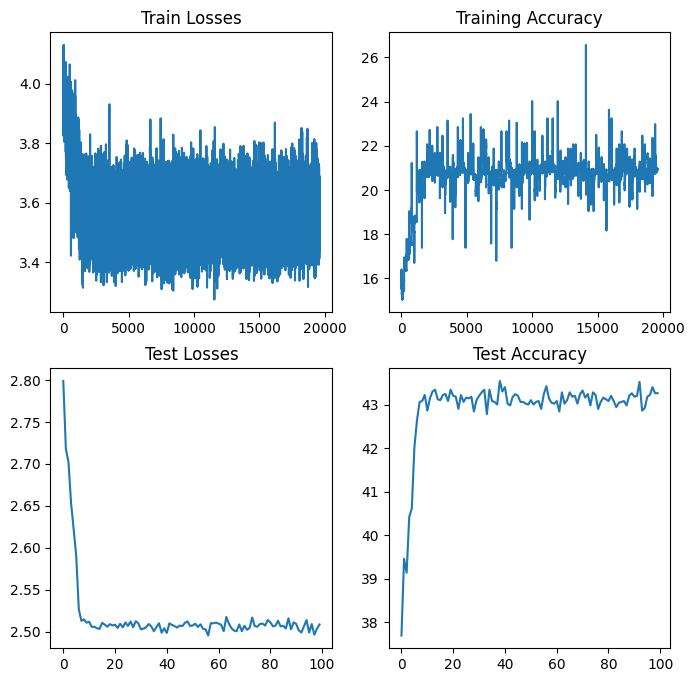

In [9]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)

# Epsilion 0.01

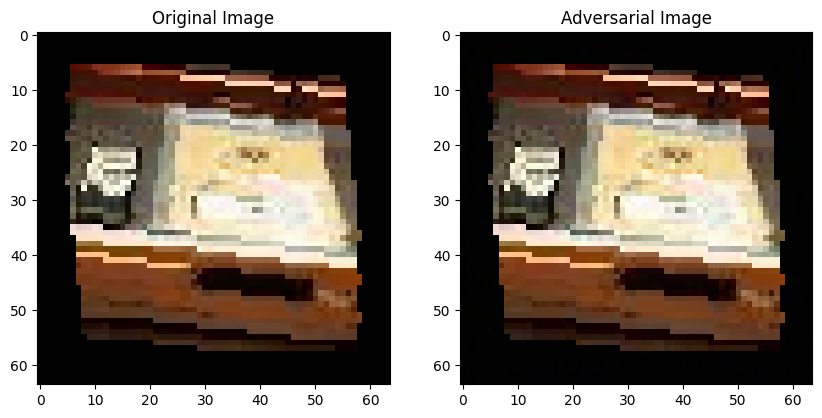

In [10]:
epsilon=0.01
mean=MeanImagenet
std=StdImagenet
model=ResNet18_TINYIMAGENET_0P
trainloader=trainloader_TINYIMAGENET
testloader=testloader_TINYIMAGENET

#Check Images for epsion levels
for data, target in trainloader:
    data, target = data.to(device), target.to(device)
    data_Adv=GetAdversarialExamples(model, data, target, device, epsilon=epsilon, mean=mean, std=std)

    data = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data)
    data_Adv = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data_Adv)
    break

IdxImage=np.random.randint(0,data.shape[0])
with torch.no_grad():
    #plot an image from data and from data_Adv
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(data[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(data_Adv[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Adversarial Image")
    plt.show()


In [11]:
epsilon=0.01
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 100

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses, epsilon, mean, std)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)
    
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/ResNet18_TinyImagenet_V0_Adversarial_ep_1p.pt")
        np.savez("./Networks/TrainSteps_ResNet18_TinyImagenet_V0_Adversarial_ep_1p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/ResNet18_TinyImagenet_V0_Adversarial_ep_1p.pt")
np.savez("./Networks/TrainSteps_ResNet18_TinyImagenet_V0_Adversarial_ep_1p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

EPOCHS : 0


Loss=2.51875901222229 Batch_id=195 Accuracy=38.63: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]  



Test set: Average loss: 2.0739, Accuracy: 2559/5000 (51.18%)

EPOCHS : 1


Loss=2.492018699645996 Batch_id=195 Accuracy=40.38: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s] 



Test set: Average loss: 2.0079, Accuracy: 2580/5000 (51.60%)

EPOCHS : 2


Loss=2.39713978767395 Batch_id=195 Accuracy=41.52: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]  



Test set: Average loss: 1.9795, Accuracy: 2632/5000 (52.64%)

EPOCHS : 3


Loss=2.3340227603912354 Batch_id=195 Accuracy=42.65: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s]



Test set: Average loss: 1.9751, Accuracy: 2635/5000 (52.70%)

EPOCHS : 4


Loss=2.455207347869873 Batch_id=195 Accuracy=43.50: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s] 



Test set: Average loss: 1.9640, Accuracy: 2621/5000 (52.42%)

EPOCHS : 5


Loss=2.0812554359436035 Batch_id=195 Accuracy=44.33: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.9369, Accuracy: 2689/5000 (53.78%)

EPOCHS : 6


Loss=2.0271921157836914 Batch_id=195 Accuracy=44.73: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]



Test set: Average loss: 1.9475, Accuracy: 2713/5000 (54.26%)

EPOCHS : 7


Loss=2.0301406383514404 Batch_id=195 Accuracy=45.67: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s]



Test set: Average loss: 1.9822, Accuracy: 2648/5000 (52.96%)

EPOCHS : 8


Loss=2.1353464126586914 Batch_id=195 Accuracy=46.18: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 1.9246, Accuracy: 2742/5000 (54.84%)

EPOCHS : 9


Loss=2.082650661468506 Batch_id=195 Accuracy=47.02: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s] 

Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 1.9149, Accuracy: 2715/5000 (54.30%)

EPOCHS : 10


Loss=1.9364261627197266 Batch_id=195 Accuracy=51.38: 100%|██████████| 196/196 [02:32<00:00,  1.28it/s]



Test set: Average loss: 1.8414, Accuracy: 2796/5000 (55.92%)

EPOCHS : 11


Loss=1.811838150024414 Batch_id=195 Accuracy=52.50: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 1.8350, Accuracy: 2819/5000 (56.38%)

EPOCHS : 12


Loss=1.8171151876449585 Batch_id=195 Accuracy=52.88: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8334, Accuracy: 2825/5000 (56.50%)

EPOCHS : 13


Loss=2.0249900817871094 Batch_id=195 Accuracy=53.19: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 1.8358, Accuracy: 2813/5000 (56.26%)

EPOCHS : 14


Loss=1.672485113143921 Batch_id=195 Accuracy=53.29: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s] 



Test set: Average loss: 1.8296, Accuracy: 2829/5000 (56.58%)

EPOCHS : 15


Loss=1.8698713779449463 Batch_id=195 Accuracy=53.20: 100%|██████████| 196/196 [02:32<00:00,  1.29it/s]



Test set: Average loss: 1.8273, Accuracy: 2833/5000 (56.66%)

EPOCHS : 16


Loss=1.986440896987915 Batch_id=195 Accuracy=53.68: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s] 



Test set: Average loss: 1.8328, Accuracy: 2820/5000 (56.40%)

EPOCHS : 17


Loss=2.0468802452087402 Batch_id=195 Accuracy=53.72: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]

Epoch 00018: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 1.8300, Accuracy: 2829/5000 (56.58%)

EPOCHS : 18


Loss=1.7554280757904053 Batch_id=195 Accuracy=54.15: 100%|██████████| 196/196 [02:37<00:00,  1.25it/s]



Test set: Average loss: 1.8291, Accuracy: 2820/5000 (56.40%)

EPOCHS : 19


Loss=1.698485016822815 Batch_id=195 Accuracy=53.87: 100%|██████████| 196/196 [02:36<00:00,  1.26it/s] 



Test set: Average loss: 1.8295, Accuracy: 2817/5000 (56.34%)

EPOCHS : 20


Loss=1.8464800119400024 Batch_id=195 Accuracy=54.13: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]

Epoch 00021: reducing learning rate of group 0 to 1.2500e-06.



Test set: Average loss: 1.8333, Accuracy: 2823/5000 (56.46%)

EPOCHS : 21


Loss=1.7406364679336548 Batch_id=195 Accuracy=54.16: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8264, Accuracy: 2833/5000 (56.66%)

EPOCHS : 22


Loss=1.736280083656311 Batch_id=195 Accuracy=54.17: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s] 



Test set: Average loss: 1.8294, Accuracy: 2817/5000 (56.34%)

EPOCHS : 23


Loss=2.0179383754730225 Batch_id=195 Accuracy=54.07: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]

Epoch 00024: reducing learning rate of group 0 to 6.2500e-08.



Test set: Average loss: 1.8311, Accuracy: 2830/5000 (56.60%)

EPOCHS : 24


Loss=1.8322389125823975 Batch_id=195 Accuracy=54.08: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 1.8315, Accuracy: 2820/5000 (56.40%)

EPOCHS : 25


Loss=1.849513292312622 Batch_id=195 Accuracy=53.91: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s] 



Test set: Average loss: 1.8268, Accuracy: 2823/5000 (56.46%)

EPOCHS : 26


Loss=1.5499670505523682 Batch_id=195 Accuracy=54.33: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8290, Accuracy: 2810/5000 (56.20%)

EPOCHS : 27


Loss=1.736022710800171 Batch_id=195 Accuracy=54.01: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 1.8313, Accuracy: 2836/5000 (56.72%)

EPOCHS : 28


Loss=1.6933624744415283 Batch_id=195 Accuracy=54.18: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s]



Test set: Average loss: 1.8284, Accuracy: 2819/5000 (56.38%)

EPOCHS : 29


Loss=1.7934999465942383 Batch_id=195 Accuracy=54.12: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]

Epoch 00030: reducing learning rate of group 0 to 3.1250e-09.



Test set: Average loss: 1.8293, Accuracy: 2827/5000 (56.54%)

EPOCHS : 30


Loss=1.9239963293075562 Batch_id=195 Accuracy=54.17: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]



Test set: Average loss: 1.8326, Accuracy: 2827/5000 (56.54%)

EPOCHS : 31


Loss=2.1359221935272217 Batch_id=195 Accuracy=54.09: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8328, Accuracy: 2822/5000 (56.44%)

EPOCHS : 32


Loss=1.8423233032226562 Batch_id=195 Accuracy=54.15: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s]



Test set: Average loss: 1.8303, Accuracy: 2823/5000 (56.46%)

EPOCHS : 33


Loss=1.771528959274292 Batch_id=195 Accuracy=54.14: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s] 



Test set: Average loss: 1.8276, Accuracy: 2829/5000 (56.58%)

EPOCHS : 34


Loss=1.6556813716888428 Batch_id=195 Accuracy=54.04: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8291, Accuracy: 2822/5000 (56.44%)

EPOCHS : 35


Loss=1.711648941040039 Batch_id=195 Accuracy=54.19: 100%|██████████| 196/196 [02:32<00:00,  1.28it/s] 



Test set: Average loss: 1.8319, Accuracy: 2830/5000 (56.60%)

EPOCHS : 36


Loss=1.756061315536499 Batch_id=195 Accuracy=53.95: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s] 



Test set: Average loss: 1.8273, Accuracy: 2828/5000 (56.56%)

EPOCHS : 37


Loss=1.7533155679702759 Batch_id=195 Accuracy=54.11: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 1.8310, Accuracy: 2834/5000 (56.68%)

EPOCHS : 38


Loss=1.757987380027771 Batch_id=195 Accuracy=54.06: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s] 



Test set: Average loss: 1.8300, Accuracy: 2821/5000 (56.42%)

EPOCHS : 39


Loss=1.6959253549575806 Batch_id=195 Accuracy=54.09: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 1.8346, Accuracy: 2812/5000 (56.24%)

EPOCHS : 40


Loss=1.7333139181137085 Batch_id=195 Accuracy=54.07: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 1.8272, Accuracy: 2828/5000 (56.56%)

EPOCHS : 41


Loss=1.597707986831665 Batch_id=195 Accuracy=54.06: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s] 



Test set: Average loss: 1.8271, Accuracy: 2825/5000 (56.50%)

EPOCHS : 42


Loss=1.8341974020004272 Batch_id=195 Accuracy=54.02: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 1.8249, Accuracy: 2829/5000 (56.58%)

EPOCHS : 43


Loss=1.7854448556900024 Batch_id=195 Accuracy=54.17: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 1.8294, Accuracy: 2827/5000 (56.54%)

EPOCHS : 44


Loss=1.6375577449798584 Batch_id=195 Accuracy=54.13: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8288, Accuracy: 2821/5000 (56.42%)

EPOCHS : 45


Loss=1.9484565258026123 Batch_id=195 Accuracy=54.12: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]



Test set: Average loss: 1.8300, Accuracy: 2820/5000 (56.40%)

EPOCHS : 46


Loss=1.7798421382904053 Batch_id=195 Accuracy=54.05: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 1.8294, Accuracy: 2823/5000 (56.46%)

EPOCHS : 47


Loss=1.8094688653945923 Batch_id=195 Accuracy=54.29: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8268, Accuracy: 2825/5000 (56.50%)

EPOCHS : 48


Loss=1.7166894674301147 Batch_id=195 Accuracy=54.18: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8253, Accuracy: 2827/5000 (56.54%)

EPOCHS : 49


Loss=1.7502410411834717 Batch_id=195 Accuracy=54.21: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s]



Test set: Average loss: 1.8276, Accuracy: 2826/5000 (56.52%)

EPOCHS : 50


Loss=1.7931257486343384 Batch_id=195 Accuracy=54.20: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s]



Test set: Average loss: 1.8293, Accuracy: 2825/5000 (56.50%)

EPOCHS : 51


Loss=1.6581048965454102 Batch_id=195 Accuracy=54.07: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s]



Test set: Average loss: 1.8267, Accuracy: 2824/5000 (56.48%)

EPOCHS : 52


Loss=1.8422458171844482 Batch_id=195 Accuracy=54.03: 100%|██████████| 196/196 [02:32<00:00,  1.29it/s]



Test set: Average loss: 1.8295, Accuracy: 2828/5000 (56.56%)

EPOCHS : 53


Loss=1.8453540802001953 Batch_id=195 Accuracy=53.97: 100%|██████████| 196/196 [02:30<00:00,  1.31it/s]



Test set: Average loss: 1.8307, Accuracy: 2824/5000 (56.48%)

EPOCHS : 54


Loss=1.6704094409942627 Batch_id=195 Accuracy=54.29: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8286, Accuracy: 2823/5000 (56.46%)

EPOCHS : 55


Loss=1.9252502918243408 Batch_id=195 Accuracy=54.14: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]



Test set: Average loss: 1.8280, Accuracy: 2825/5000 (56.50%)

EPOCHS : 56


Loss=1.637420654296875 Batch_id=195 Accuracy=54.10: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s] 



Test set: Average loss: 1.8343, Accuracy: 2822/5000 (56.44%)

EPOCHS : 57


Loss=1.9749538898468018 Batch_id=195 Accuracy=54.03: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8314, Accuracy: 2827/5000 (56.54%)

EPOCHS : 58


Loss=1.7131141424179077 Batch_id=195 Accuracy=54.22: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8336, Accuracy: 2815/5000 (56.30%)

EPOCHS : 59


Loss=1.4441545009613037 Batch_id=195 Accuracy=54.08: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s]



Test set: Average loss: 1.8284, Accuracy: 2823/5000 (56.46%)

EPOCHS : 60


Loss=1.7119992971420288 Batch_id=195 Accuracy=54.00: 100%|██████████| 196/196 [02:32<00:00,  1.29it/s]



Test set: Average loss: 1.8312, Accuracy: 2814/5000 (56.28%)

EPOCHS : 61


Loss=1.7003698348999023 Batch_id=195 Accuracy=54.13: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s]



Test set: Average loss: 1.8273, Accuracy: 2825/5000 (56.50%)

EPOCHS : 62


Loss=1.66448974609375 Batch_id=195 Accuracy=53.94: 100%|██████████| 196/196 [02:30<00:00,  1.31it/s]  



Test set: Average loss: 1.8285, Accuracy: 2825/5000 (56.50%)

EPOCHS : 63


Loss=1.7649633884429932 Batch_id=195 Accuracy=54.04: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s]



Test set: Average loss: 1.8325, Accuracy: 2829/5000 (56.58%)

EPOCHS : 64


Loss=1.764983892440796 Batch_id=195 Accuracy=54.23: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s] 



Test set: Average loss: 1.8297, Accuracy: 2826/5000 (56.52%)

EPOCHS : 65


Loss=1.8998463153839111 Batch_id=195 Accuracy=54.20: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8304, Accuracy: 2827/5000 (56.54%)

EPOCHS : 66


Loss=1.5413674116134644 Batch_id=195 Accuracy=54.09: 100%|██████████| 196/196 [02:31<00:00,  1.30it/s]



Test set: Average loss: 1.8285, Accuracy: 2822/5000 (56.44%)

EPOCHS : 67


Loss=1.8619635105133057 Batch_id=195 Accuracy=53.84: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8333, Accuracy: 2820/5000 (56.40%)

EPOCHS : 68


Loss=1.6410338878631592 Batch_id=195 Accuracy=53.87: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]



Test set: Average loss: 1.8249, Accuracy: 2823/5000 (56.46%)

EPOCHS : 69


Loss=1.8120571374893188 Batch_id=195 Accuracy=54.16: 100%|██████████| 196/196 [02:32<00:00,  1.29it/s]



Test set: Average loss: 1.8281, Accuracy: 2820/5000 (56.40%)

EPOCHS : 70


Loss=1.613741159439087 Batch_id=195 Accuracy=53.91: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s] 



Test set: Average loss: 1.8272, Accuracy: 2824/5000 (56.48%)

EPOCHS : 71


Loss=1.6236165761947632 Batch_id=195 Accuracy=54.06: 100%|██████████| 196/196 [02:30<00:00,  1.31it/s]



Test set: Average loss: 1.8322, Accuracy: 2815/5000 (56.30%)

EPOCHS : 72


Loss=1.8354419469833374 Batch_id=195 Accuracy=54.21: 100%|██████████| 196/196 [02:32<00:00,  1.28it/s]



Test set: Average loss: 1.8283, Accuracy: 2825/5000 (56.50%)

EPOCHS : 73


Loss=1.8187477588653564 Batch_id=195 Accuracy=54.14: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]



Test set: Average loss: 1.8290, Accuracy: 2822/5000 (56.44%)

EPOCHS : 74


Loss=2.0456576347351074 Batch_id=195 Accuracy=54.24: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 1.8335, Accuracy: 2822/5000 (56.44%)

EPOCHS : 75


Loss=1.7086308002471924 Batch_id=195 Accuracy=54.12: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]



Test set: Average loss: 1.8303, Accuracy: 2817/5000 (56.34%)

EPOCHS : 76


Loss=1.7834144830703735 Batch_id=195 Accuracy=54.18: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]



Test set: Average loss: 1.8330, Accuracy: 2814/5000 (56.28%)

EPOCHS : 77


Loss=1.6866750717163086 Batch_id=195 Accuracy=54.05: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]



Test set: Average loss: 1.8299, Accuracy: 2819/5000 (56.38%)

EPOCHS : 78


Loss=1.9286887645721436 Batch_id=195 Accuracy=54.03: 100%|██████████| 196/196 [02:32<00:00,  1.28it/s]



Test set: Average loss: 1.8286, Accuracy: 2822/5000 (56.44%)

EPOCHS : 79


Loss=1.9477813243865967 Batch_id=195 Accuracy=54.10: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 1.8301, Accuracy: 2829/5000 (56.58%)

EPOCHS : 80


Loss=1.6518657207489014 Batch_id=195 Accuracy=54.17: 100%|██████████| 196/196 [02:31<00:00,  1.29it/s]



Test set: Average loss: 1.8304, Accuracy: 2828/5000 (56.56%)

EPOCHS : 81


Loss=1.74481201171875 Batch_id=195 Accuracy=54.11: 100%|██████████| 196/196 [02:38<00:00,  1.23it/s]  



Test set: Average loss: 1.8321, Accuracy: 2823/5000 (56.46%)

EPOCHS : 82


Loss=1.9230972528457642 Batch_id=195 Accuracy=54.06: 100%|██████████| 196/196 [02:36<00:00,  1.25it/s]



Test set: Average loss: 1.8294, Accuracy: 2826/5000 (56.52%)

EPOCHS : 83


Loss=1.678493857383728 Batch_id=195 Accuracy=54.10: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s] 



Test set: Average loss: 1.8299, Accuracy: 2821/5000 (56.42%)

EPOCHS : 84


Loss=1.7622601985931396 Batch_id=195 Accuracy=54.01: 100%|██████████| 196/196 [02:30<00:00,  1.30it/s]



Test set: Average loss: 1.8299, Accuracy: 2827/5000 (56.54%)

EPOCHS : 85


Loss=1.9619611501693726 Batch_id=195 Accuracy=54.25: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 1.8255, Accuracy: 2826/5000 (56.52%)

EPOCHS : 86


Loss=1.9785592555999756 Batch_id=195 Accuracy=54.06: 100%|██████████| 196/196 [02:28<00:00,  1.32it/s]



Test set: Average loss: 1.8266, Accuracy: 2827/5000 (56.54%)

EPOCHS : 87


Loss=1.8002631664276123 Batch_id=195 Accuracy=53.93: 100%|██████████| 196/196 [02:29<00:00,  1.31it/s]



Test set: Average loss: 1.8261, Accuracy: 2815/5000 (56.30%)

EPOCHS : 88


Loss=1.849321961402893 Batch_id=195 Accuracy=54.21: 100%|██████████| 196/196 [03:42<00:00,  1.14s/it] 



Test set: Average loss: 1.8316, Accuracy: 2826/5000 (56.52%)

EPOCHS : 89


Loss=1.8506778478622437 Batch_id=195 Accuracy=54.01: 100%|██████████| 196/196 [03:52<00:00,  1.19s/it]



Test set: Average loss: 1.8282, Accuracy: 2818/5000 (56.36%)

EPOCHS : 90


Loss=1.8617162704467773 Batch_id=195 Accuracy=54.06: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.8294, Accuracy: 2820/5000 (56.40%)

EPOCHS : 91


Loss=1.7501027584075928 Batch_id=195 Accuracy=54.01: 100%|██████████| 196/196 [03:46<00:00,  1.16s/it]



Test set: Average loss: 1.8249, Accuracy: 2829/5000 (56.58%)

EPOCHS : 92


Loss=1.7489020824432373 Batch_id=195 Accuracy=54.14: 100%|██████████| 196/196 [03:46<00:00,  1.16s/it]



Test set: Average loss: 1.8283, Accuracy: 2825/5000 (56.50%)

EPOCHS : 93


Loss=1.611608862876892 Batch_id=195 Accuracy=53.92: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it] 



Test set: Average loss: 1.8273, Accuracy: 2811/5000 (56.22%)

EPOCHS : 94


Loss=1.8672593832015991 Batch_id=195 Accuracy=54.14: 100%|██████████| 196/196 [03:46<00:00,  1.16s/it]



Test set: Average loss: 1.8335, Accuracy: 2819/5000 (56.38%)

EPOCHS : 95


Loss=1.6111444234848022 Batch_id=195 Accuracy=53.90: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.8316, Accuracy: 2823/5000 (56.46%)

EPOCHS : 96


Loss=1.713832139968872 Batch_id=195 Accuracy=54.27: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it] 



Test set: Average loss: 1.8314, Accuracy: 2814/5000 (56.28%)

EPOCHS : 97


Loss=1.7944618463516235 Batch_id=195 Accuracy=54.00: 100%|██████████| 196/196 [03:46<00:00,  1.16s/it]



Test set: Average loss: 1.8263, Accuracy: 2815/5000 (56.30%)

EPOCHS : 98


Loss=1.9521898031234741 Batch_id=195 Accuracy=54.12: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.8319, Accuracy: 2820/5000 (56.40%)

EPOCHS : 99


Loss=1.7790498733520508 Batch_id=195 Accuracy=54.03: 100%|██████████| 196/196 [03:45<00:00,  1.15s/it]



Test set: Average loss: 1.8305, Accuracy: 2814/5000 (56.28%)



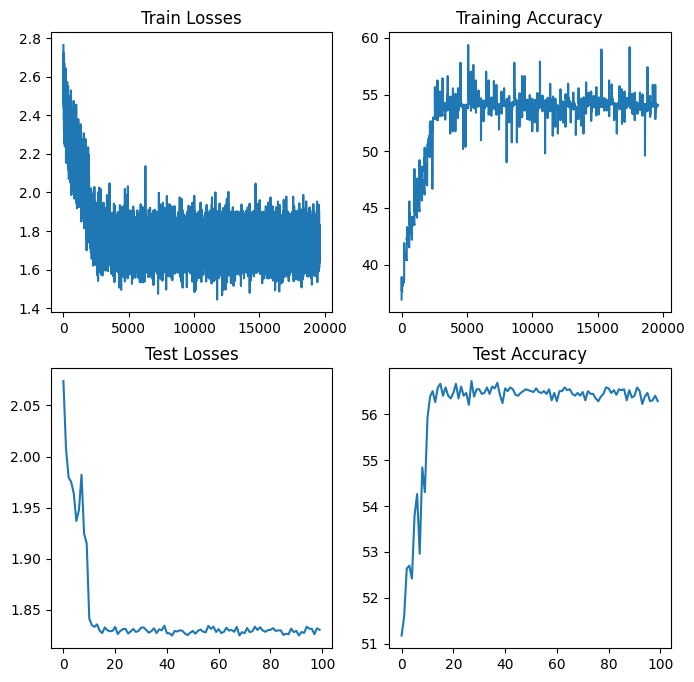

In [12]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)

# Epsilon 0.005

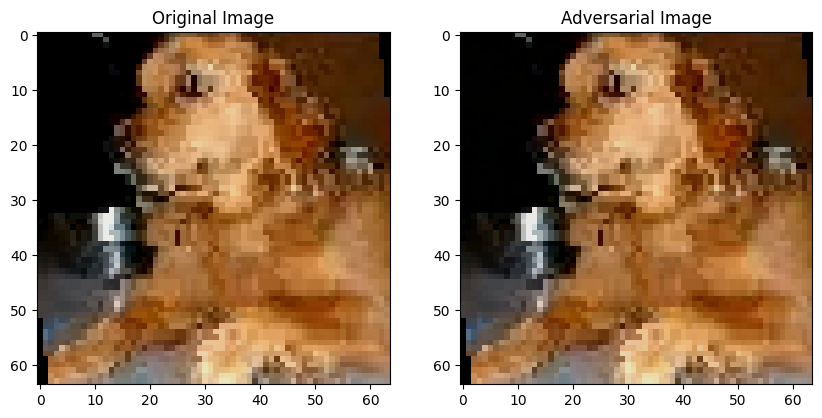

In [13]:
epsilon=0.005
mean=MeanImagenet
std=StdImagenet
model=ResNet18_TINYIMAGENET_0P
trainloader=trainloader_TINYIMAGENET
testloader=testloader_TINYIMAGENET

#Check Images for epsion levels
for data, target in trainloader:
    data, target = data.to(device), target.to(device)
    data_Adv=GetAdversarialExamples(model, data, target, device, epsilon=epsilon, mean=mean, std=std)

    data = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data)
    data_Adv = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data_Adv)
    break

IdxImage=np.random.randint(0,data.shape[0])
with torch.no_grad():
    #plot an image from data and from data_Adv
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(data[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(data_Adv[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Adversarial Image")
    plt.show()


In [14]:
epsilon=0.005
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 100

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses, epsilon, mean, std)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)
    
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/ResNet18_TinyImagenet_V0_Adversarial_ep_05p.pt")
        np.savez("./Networks/TrainSteps_ResNet18_TinyImagenet_V0_Adversarial_ep_05p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/ResNet18_TinyImagenet_V0_Adversarial_ep_05p.pt")
np.savez("./Networks/TrainSteps_ResNet18_TinyImagenet_V0_Adversarial_ep_05p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

EPOCHS : 0


Loss=1.5076111555099487 Batch_id=195 Accuracy=62.04: 100%|██████████| 196/196 [03:50<00:00,  1.18s/it]



Test set: Average loss: 1.8622, Accuracy: 2798/5000 (55.96%)

EPOCHS : 1


Loss=1.4828283786773682 Batch_id=195 Accuracy=61.99: 100%|██████████| 196/196 [03:46<00:00,  1.16s/it]



Test set: Average loss: 1.8576, Accuracy: 2808/5000 (56.16%)

EPOCHS : 2


Loss=1.4888830184936523 Batch_id=195 Accuracy=62.52: 100%|██████████| 196/196 [03:48<00:00,  1.16s/it]



Test set: Average loss: 1.8892, Accuracy: 2794/5000 (55.88%)

EPOCHS : 3


Loss=1.517279863357544 Batch_id=195 Accuracy=62.99: 100%|██████████| 196/196 [03:46<00:00,  1.15s/it] 



Test set: Average loss: 1.8553, Accuracy: 2820/5000 (56.40%)

EPOCHS : 4


Loss=1.4948097467422485 Batch_id=195 Accuracy=63.75: 100%|██████████| 196/196 [03:51<00:00,  1.18s/it]

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 1.8625, Accuracy: 2853/5000 (57.06%)

EPOCHS : 5


Loss=1.1426409482955933 Batch_id=195 Accuracy=68.31: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it]



Test set: Average loss: 1.7765, Accuracy: 2902/5000 (58.04%)

EPOCHS : 6


Loss=1.1571890115737915 Batch_id=195 Accuracy=69.85: 100%|██████████| 196/196 [03:45<00:00,  1.15s/it]



Test set: Average loss: 1.7621, Accuracy: 2904/5000 (58.08%)

EPOCHS : 7


Loss=1.0758763551712036 Batch_id=195 Accuracy=70.25: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7622, Accuracy: 2912/5000 (58.24%)

EPOCHS : 8


Loss=1.193887710571289 Batch_id=195 Accuracy=70.70: 100%|██████████| 196/196 [03:43<00:00,  1.14s/it] 



Test set: Average loss: 1.7619, Accuracy: 2930/5000 (58.60%)

EPOCHS : 9


Loss=1.0107479095458984 Batch_id=195 Accuracy=70.99: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7615, Accuracy: 2920/5000 (58.40%)

EPOCHS : 10


Loss=1.2610456943511963 Batch_id=195 Accuracy=70.93: 100%|██████████| 196/196 [03:48<00:00,  1.16s/it]



Test set: Average loss: 1.7666, Accuracy: 2920/5000 (58.40%)

EPOCHS : 11


Loss=1.145615816116333 Batch_id=195 Accuracy=71.11: 100%|██████████| 196/196 [03:48<00:00,  1.16s/it] 



Test set: Average loss: 1.7684, Accuracy: 2921/5000 (58.42%)

EPOCHS : 12


Loss=0.9101070165634155 Batch_id=195 Accuracy=71.15: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it]



Test set: Average loss: 1.7625, Accuracy: 2929/5000 (58.58%)

EPOCHS : 13


Loss=0.9952436685562134 Batch_id=195 Accuracy=71.31: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7625, Accuracy: 2920/5000 (58.40%)

EPOCHS : 14


Loss=1.0156543254852295 Batch_id=195 Accuracy=71.45: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it]



Test set: Average loss: 1.7582, Accuracy: 2927/5000 (58.54%)

EPOCHS : 15


Loss=1.112207293510437 Batch_id=195 Accuracy=71.72: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it] 

Epoch 00016: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 1.7704, Accuracy: 2917/5000 (58.34%)

EPOCHS : 16


Loss=0.9968894720077515 Batch_id=195 Accuracy=71.99: 100%|██████████| 196/196 [03:50<00:00,  1.17s/it]



Test set: Average loss: 1.7644, Accuracy: 2932/5000 (58.64%)

EPOCHS : 17


Loss=1.0655043125152588 Batch_id=195 Accuracy=71.91: 100%|██████████| 196/196 [03:45<00:00,  1.15s/it]



Test set: Average loss: 1.7650, Accuracy: 2922/5000 (58.44%)

EPOCHS : 18


Loss=1.1607869863510132 Batch_id=195 Accuracy=71.92: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it]

Epoch 00019: reducing learning rate of group 0 to 1.2500e-06.



Test set: Average loss: 1.7611, Accuracy: 2924/5000 (58.48%)

EPOCHS : 19


Loss=0.9694099426269531 Batch_id=195 Accuracy=71.97: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it]



Test set: Average loss: 1.7640, Accuracy: 2926/5000 (58.52%)

EPOCHS : 20


Loss=0.9556987881660461 Batch_id=195 Accuracy=71.96: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it]



Test set: Average loss: 1.7649, Accuracy: 2919/5000 (58.38%)

EPOCHS : 21


Loss=0.9971359968185425 Batch_id=195 Accuracy=72.02: 100%|██████████| 196/196 [03:50<00:00,  1.17s/it]

Epoch 00022: reducing learning rate of group 0 to 6.2500e-08.



Test set: Average loss: 1.7664, Accuracy: 2922/5000 (58.44%)

EPOCHS : 22


Loss=1.225909948348999 Batch_id=195 Accuracy=71.73: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it] 



Test set: Average loss: 1.7641, Accuracy: 2933/5000 (58.66%)

EPOCHS : 23


Loss=0.9609125256538391 Batch_id=195 Accuracy=71.94: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it]



Test set: Average loss: 1.7617, Accuracy: 2930/5000 (58.60%)

EPOCHS : 24


Loss=1.0845720767974854 Batch_id=195 Accuracy=71.93: 100%|██████████| 196/196 [03:45<00:00,  1.15s/it]

Epoch 00025: reducing learning rate of group 0 to 3.1250e-09.



Test set: Average loss: 1.7694, Accuracy: 2911/5000 (58.22%)

EPOCHS : 25


Loss=1.0609781742095947 Batch_id=195 Accuracy=71.88: 100%|██████████| 196/196 [03:48<00:00,  1.16s/it]



Test set: Average loss: 1.7657, Accuracy: 2917/5000 (58.34%)

EPOCHS : 26


Loss=1.0501728057861328 Batch_id=195 Accuracy=72.00: 100%|██████████| 196/196 [03:51<00:00,  1.18s/it]



Test set: Average loss: 1.7648, Accuracy: 2929/5000 (58.58%)

EPOCHS : 27


Loss=1.1238820552825928 Batch_id=195 Accuracy=72.12: 100%|██████████| 196/196 [03:50<00:00,  1.18s/it]



Test set: Average loss: 1.7667, Accuracy: 2917/5000 (58.34%)

EPOCHS : 28


Loss=1.2898298501968384 Batch_id=195 Accuracy=72.15: 100%|██████████| 196/196 [03:48<00:00,  1.16s/it]



Test set: Average loss: 1.7659, Accuracy: 2927/5000 (58.54%)

EPOCHS : 29


Loss=1.0731091499328613 Batch_id=195 Accuracy=72.02: 100%|██████████| 196/196 [03:46<00:00,  1.16s/it]



Test set: Average loss: 1.7648, Accuracy: 2922/5000 (58.44%)

EPOCHS : 30


Loss=0.9678524732589722 Batch_id=195 Accuracy=71.88: 100%|██████████| 196/196 [03:46<00:00,  1.16s/it]



Test set: Average loss: 1.7638, Accuracy: 2924/5000 (58.48%)

EPOCHS : 31


Loss=1.1289104223251343 Batch_id=195 Accuracy=72.09: 100%|██████████| 196/196 [03:46<00:00,  1.16s/it]



Test set: Average loss: 1.7663, Accuracy: 2917/5000 (58.34%)

EPOCHS : 32


Loss=0.973315417766571 Batch_id=195 Accuracy=72.11: 100%|██████████| 196/196 [03:45<00:00,  1.15s/it] 



Test set: Average loss: 1.7618, Accuracy: 2925/5000 (58.50%)

EPOCHS : 33


Loss=1.2389962673187256 Batch_id=195 Accuracy=72.00: 100%|██████████| 196/196 [03:45<00:00,  1.15s/it]



Test set: Average loss: 1.7645, Accuracy: 2921/5000 (58.42%)

EPOCHS : 34


Loss=0.9805442690849304 Batch_id=195 Accuracy=72.00: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7635, Accuracy: 2927/5000 (58.54%)

EPOCHS : 35


Loss=1.02383291721344 Batch_id=195 Accuracy=72.03: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it]  



Test set: Average loss: 1.7664, Accuracy: 2916/5000 (58.32%)

EPOCHS : 36


Loss=1.132232904434204 Batch_id=195 Accuracy=72.12: 100%|██████████| 196/196 [03:51<00:00,  1.18s/it] 



Test set: Average loss: 1.7645, Accuracy: 2926/5000 (58.52%)

EPOCHS : 37


Loss=1.1888126134872437 Batch_id=195 Accuracy=72.09: 100%|██████████| 196/196 [03:46<00:00,  1.16s/it]



Test set: Average loss: 1.7653, Accuracy: 2941/5000 (58.82%)

EPOCHS : 38


Loss=1.0963735580444336 Batch_id=195 Accuracy=71.94: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7631, Accuracy: 2938/5000 (58.76%)

EPOCHS : 39


Loss=1.1073706150054932 Batch_id=195 Accuracy=72.13: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7623, Accuracy: 2935/5000 (58.70%)

EPOCHS : 40


Loss=1.0952982902526855 Batch_id=195 Accuracy=72.12: 100%|██████████| 196/196 [03:50<00:00,  1.18s/it]



Test set: Average loss: 1.7670, Accuracy: 2918/5000 (58.36%)

EPOCHS : 41


Loss=1.0940089225769043 Batch_id=195 Accuracy=71.83: 100%|██████████| 196/196 [03:45<00:00,  1.15s/it]



Test set: Average loss: 1.7622, Accuracy: 2938/5000 (58.76%)

EPOCHS : 42


Loss=1.219215989112854 Batch_id=195 Accuracy=72.00: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it] 



Test set: Average loss: 1.7647, Accuracy: 2933/5000 (58.66%)

EPOCHS : 43


Loss=1.0461543798446655 Batch_id=195 Accuracy=71.92: 100%|██████████| 196/196 [03:51<00:00,  1.18s/it]



Test set: Average loss: 1.7614, Accuracy: 2919/5000 (58.38%)

EPOCHS : 44


Loss=1.063910722732544 Batch_id=195 Accuracy=71.84: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it] 



Test set: Average loss: 1.7607, Accuracy: 2934/5000 (58.68%)

EPOCHS : 45


Loss=0.9874523282051086 Batch_id=195 Accuracy=72.01: 100%|██████████| 196/196 [03:51<00:00,  1.18s/it]



Test set: Average loss: 1.7646, Accuracy: 2927/5000 (58.54%)

EPOCHS : 46


Loss=0.8509524464607239 Batch_id=195 Accuracy=71.79: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7649, Accuracy: 2923/5000 (58.46%)

EPOCHS : 47


Loss=0.8197265863418579 Batch_id=195 Accuracy=72.11: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it]



Test set: Average loss: 1.7622, Accuracy: 2917/5000 (58.34%)

EPOCHS : 48


Loss=1.2331219911575317 Batch_id=195 Accuracy=72.00: 100%|██████████| 196/196 [03:48<00:00,  1.16s/it]



Test set: Average loss: 1.7692, Accuracy: 2922/5000 (58.44%)

EPOCHS : 49


Loss=1.190003514289856 Batch_id=195 Accuracy=71.90: 100%|██████████| 196/196 [03:48<00:00,  1.16s/it] 



Test set: Average loss: 1.7643, Accuracy: 2928/5000 (58.56%)

EPOCHS : 50


Loss=1.166577935218811 Batch_id=195 Accuracy=71.94: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it] 



Test set: Average loss: 1.7642, Accuracy: 2926/5000 (58.52%)

EPOCHS : 51


Loss=1.0076613426208496 Batch_id=195 Accuracy=71.91: 100%|██████████| 196/196 [03:53<00:00,  1.19s/it]



Test set: Average loss: 1.7671, Accuracy: 2918/5000 (58.36%)

EPOCHS : 52


Loss=1.0151231288909912 Batch_id=195 Accuracy=71.90: 100%|██████████| 196/196 [03:48<00:00,  1.16s/it]



Test set: Average loss: 1.7654, Accuracy: 2927/5000 (58.54%)

EPOCHS : 53


Loss=0.9546303749084473 Batch_id=195 Accuracy=71.99: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it]



Test set: Average loss: 1.7680, Accuracy: 2920/5000 (58.40%)

EPOCHS : 54


Loss=0.877885639667511 Batch_id=195 Accuracy=71.97: 100%|██████████| 196/196 [03:51<00:00,  1.18s/it] 



Test set: Average loss: 1.7612, Accuracy: 2913/5000 (58.26%)

EPOCHS : 55


Loss=1.0370512008666992 Batch_id=195 Accuracy=72.13: 100%|██████████| 196/196 [03:50<00:00,  1.18s/it]



Test set: Average loss: 1.7674, Accuracy: 2927/5000 (58.54%)

EPOCHS : 56


Loss=1.1239063739776611 Batch_id=195 Accuracy=71.89: 100%|██████████| 196/196 [03:56<00:00,  1.21s/it]



Test set: Average loss: 1.7643, Accuracy: 2923/5000 (58.46%)

EPOCHS : 57


Loss=1.1680920124053955 Batch_id=195 Accuracy=72.00: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7719, Accuracy: 2923/5000 (58.46%)

EPOCHS : 58


Loss=1.2185373306274414 Batch_id=195 Accuracy=72.13: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it]



Test set: Average loss: 1.7656, Accuracy: 2915/5000 (58.30%)

EPOCHS : 59


Loss=1.1029467582702637 Batch_id=195 Accuracy=72.09: 100%|██████████| 196/196 [03:40<00:00,  1.12s/it]



Test set: Average loss: 1.7648, Accuracy: 2924/5000 (58.48%)

EPOCHS : 60


Loss=1.1507624387741089 Batch_id=195 Accuracy=71.98: 100%|██████████| 196/196 [03:52<00:00,  1.18s/it]



Test set: Average loss: 1.7662, Accuracy: 2922/5000 (58.44%)

EPOCHS : 61


Loss=1.0350233316421509 Batch_id=195 Accuracy=72.09: 100%|██████████| 196/196 [03:50<00:00,  1.17s/it]



Test set: Average loss: 1.7659, Accuracy: 2921/5000 (58.42%)

EPOCHS : 62


Loss=1.0065008401870728 Batch_id=195 Accuracy=71.94: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it]



Test set: Average loss: 1.7635, Accuracy: 2938/5000 (58.76%)

EPOCHS : 63


Loss=1.0895131826400757 Batch_id=195 Accuracy=72.12: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it]



Test set: Average loss: 1.7614, Accuracy: 2925/5000 (58.50%)

EPOCHS : 64


Loss=0.9731760025024414 Batch_id=195 Accuracy=71.97: 100%|██████████| 196/196 [03:51<00:00,  1.18s/it]



Test set: Average loss: 1.7599, Accuracy: 2928/5000 (58.56%)

EPOCHS : 65


Loss=1.040872573852539 Batch_id=195 Accuracy=72.00: 100%|██████████| 196/196 [03:50<00:00,  1.17s/it] 



Test set: Average loss: 1.7621, Accuracy: 2922/5000 (58.44%)

EPOCHS : 66


Loss=0.8823214769363403 Batch_id=195 Accuracy=72.11: 100%|██████████| 196/196 [03:52<00:00,  1.18s/it]



Test set: Average loss: 1.7602, Accuracy: 2924/5000 (58.48%)

EPOCHS : 67


Loss=1.107483148574829 Batch_id=195 Accuracy=72.12: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it] 



Test set: Average loss: 1.7646, Accuracy: 2931/5000 (58.62%)

EPOCHS : 68


Loss=1.0588902235031128 Batch_id=195 Accuracy=72.05: 100%|██████████| 196/196 [03:50<00:00,  1.18s/it]



Test set: Average loss: 1.7669, Accuracy: 2920/5000 (58.40%)

EPOCHS : 69


Loss=1.2018749713897705 Batch_id=195 Accuracy=72.01: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7613, Accuracy: 2926/5000 (58.52%)

EPOCHS : 70


Loss=0.9859304428100586 Batch_id=195 Accuracy=72.07: 100%|██████████| 196/196 [03:45<00:00,  1.15s/it]



Test set: Average loss: 1.7646, Accuracy: 2931/5000 (58.62%)

EPOCHS : 71


Loss=1.101733922958374 Batch_id=195 Accuracy=72.08: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it] 



Test set: Average loss: 1.7659, Accuracy: 2917/5000 (58.34%)

EPOCHS : 72


Loss=1.0432264804840088 Batch_id=195 Accuracy=71.86: 100%|██████████| 196/196 [03:48<00:00,  1.16s/it]



Test set: Average loss: 1.7649, Accuracy: 2932/5000 (58.64%)

EPOCHS : 73


Loss=1.166230320930481 Batch_id=195 Accuracy=71.97: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it] 



Test set: Average loss: 1.7622, Accuracy: 2922/5000 (58.44%)

EPOCHS : 74


Loss=0.9455280303955078 Batch_id=195 Accuracy=71.91: 100%|██████████| 196/196 [03:50<00:00,  1.18s/it]



Test set: Average loss: 1.7642, Accuracy: 2925/5000 (58.50%)

EPOCHS : 75


Loss=1.0522865056991577 Batch_id=195 Accuracy=71.89: 100%|██████████| 196/196 [03:50<00:00,  1.17s/it]



Test set: Average loss: 1.7609, Accuracy: 2920/5000 (58.40%)

EPOCHS : 76


Loss=1.1051456928253174 Batch_id=195 Accuracy=72.12: 100%|██████████| 196/196 [03:45<00:00,  1.15s/it]



Test set: Average loss: 1.7654, Accuracy: 2934/5000 (58.68%)

EPOCHS : 77


Loss=1.124142050743103 Batch_id=195 Accuracy=72.15: 100%|██████████| 196/196 [03:52<00:00,  1.19s/it] 



Test set: Average loss: 1.7635, Accuracy: 2932/5000 (58.64%)

EPOCHS : 78


Loss=1.2685997486114502 Batch_id=195 Accuracy=72.07: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it]



Test set: Average loss: 1.7637, Accuracy: 2926/5000 (58.52%)

EPOCHS : 79


Loss=1.1658861637115479 Batch_id=195 Accuracy=71.98: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7651, Accuracy: 2920/5000 (58.40%)

EPOCHS : 80


Loss=1.171545147895813 Batch_id=195 Accuracy=72.02: 100%|██████████| 196/196 [03:52<00:00,  1.19s/it] 



Test set: Average loss: 1.7644, Accuracy: 2915/5000 (58.30%)

EPOCHS : 81


Loss=0.9291032552719116 Batch_id=195 Accuracy=71.97: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7610, Accuracy: 2932/5000 (58.64%)

EPOCHS : 82


Loss=1.0140697956085205 Batch_id=195 Accuracy=71.96: 100%|██████████| 196/196 [03:46<00:00,  1.16s/it]



Test set: Average loss: 1.7648, Accuracy: 2926/5000 (58.52%)

EPOCHS : 83


Loss=1.140599250793457 Batch_id=195 Accuracy=71.97: 100%|██████████| 196/196 [03:51<00:00,  1.18s/it] 



Test set: Average loss: 1.7661, Accuracy: 2924/5000 (58.48%)

EPOCHS : 84


Loss=1.113886833190918 Batch_id=195 Accuracy=72.10: 100%|██████████| 196/196 [03:51<00:00,  1.18s/it] 



Test set: Average loss: 1.7645, Accuracy: 2927/5000 (58.54%)

EPOCHS : 85


Loss=1.1305787563323975 Batch_id=195 Accuracy=71.89: 100%|██████████| 196/196 [03:50<00:00,  1.18s/it]



Test set: Average loss: 1.7656, Accuracy: 2918/5000 (58.36%)

EPOCHS : 86


Loss=1.112107515335083 Batch_id=195 Accuracy=72.06: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it] 



Test set: Average loss: 1.7699, Accuracy: 2910/5000 (58.20%)

EPOCHS : 87


Loss=1.1362276077270508 Batch_id=195 Accuracy=72.06: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it]



Test set: Average loss: 1.7684, Accuracy: 2926/5000 (58.52%)

EPOCHS : 88


Loss=1.0533573627471924 Batch_id=195 Accuracy=72.12: 100%|██████████| 196/196 [03:48<00:00,  1.16s/it]



Test set: Average loss: 1.7635, Accuracy: 2920/5000 (58.40%)

EPOCHS : 89


Loss=1.1322311162948608 Batch_id=195 Accuracy=72.06: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it]



Test set: Average loss: 1.7612, Accuracy: 2927/5000 (58.54%)

EPOCHS : 90


Loss=1.0872750282287598 Batch_id=195 Accuracy=72.00: 100%|██████████| 196/196 [03:47<00:00,  1.16s/it]



Test set: Average loss: 1.7628, Accuracy: 2926/5000 (58.52%)

EPOCHS : 91


Loss=1.0792436599731445 Batch_id=195 Accuracy=72.05: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it]



Test set: Average loss: 1.7618, Accuracy: 2925/5000 (58.50%)

EPOCHS : 92


Loss=1.1543159484863281 Batch_id=195 Accuracy=71.92: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7629, Accuracy: 2914/5000 (58.28%)

EPOCHS : 93


Loss=0.9843718409538269 Batch_id=195 Accuracy=71.81: 100%|██████████| 196/196 [03:48<00:00,  1.17s/it]



Test set: Average loss: 1.7672, Accuracy: 2922/5000 (58.44%)

EPOCHS : 94


Loss=1.1733601093292236 Batch_id=195 Accuracy=72.06: 100%|██████████| 196/196 [03:44<00:00,  1.14s/it]



Test set: Average loss: 1.7644, Accuracy: 2923/5000 (58.46%)

EPOCHS : 95


Loss=1.0716501474380493 Batch_id=195 Accuracy=72.01: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7629, Accuracy: 2931/5000 (58.62%)

EPOCHS : 96


Loss=1.1082890033721924 Batch_id=195 Accuracy=72.02: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7633, Accuracy: 2928/5000 (58.56%)

EPOCHS : 97


Loss=1.1933146715164185 Batch_id=195 Accuracy=71.96: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7623, Accuracy: 2934/5000 (58.68%)

EPOCHS : 98


Loss=1.0387837886810303 Batch_id=195 Accuracy=72.02: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]



Test set: Average loss: 1.7639, Accuracy: 2928/5000 (58.56%)

EPOCHS : 99


Loss=1.165889024734497 Batch_id=195 Accuracy=71.96: 100%|██████████| 196/196 [03:51<00:00,  1.18s/it] 



Test set: Average loss: 1.7649, Accuracy: 2926/5000 (58.52%)



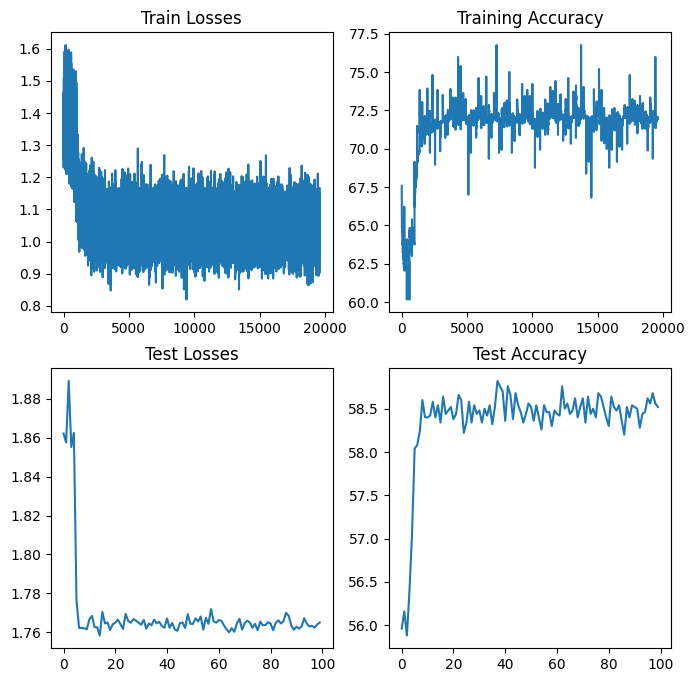

In [15]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)